# Project 2 - Income Qualification

### DESCRIPTION

Identify the level of income qualification needed for the families in Latin America.

### Problem Statement Scenario:
Many social programs have a hard time ensuring that the right people are given enough aid. It’s tricky when a program focuses on the poorest segment of the population. This segment of the population can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, a popular method called Proxy Means Test (PMT) uses an algorithm to verify income qualification. With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling or the assets found in their homes to
classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

The Inter-American Development Bank (IDB)believes that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.
### Following actions should be performed:

    1. Identify the output variable.
    2. Understand the type of data.
    3. Check if there are any biases in your dataset.
    4. Check whether all members of the house have the same poverty level.
    5. Check if there is a house without a family head.
    6. Set poverty level of the members and the head of the house within a family.
    7. Count how many null values are existing in columns.
    8. Remove null value rows of the target variable.
    9. Predict the accuracy using random forest classifier.
    10. Check the accuracy using random forest with cross validation.

### Step 1 - Importing the libraries and data set

In [1]:
# Imporing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
#from sklearn.model_selection import train_test_split as split
#from imblearn.over_sampling import SMOTE
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, SCORERS, make_scorer, f1_score

In [2]:
# Importing the data set

income_train = pd.read_csv (r'H:\Documents\Study material\Data Science course\Machine Learning\Main projects\Project 2 - Income Qualification\train.csv')
income_test = pd.read_csv (r'H:\Documents\Study material\Data Science course\Machine Learning\Main projects\Project 2 - Income Qualification\test.csv')
display (income_train.head ())
display (income_test.head ())

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


### Step 2 - Understanding the data set

In [3]:
# Checking the shape of the data set

print ("The shape of the train data set is: ", income_train.shape)
print ("The shape of the test data set is: ", income_test.shape)

The shape of the train data set is:  (9557, 143)
The shape of the test data set is:  (23856, 142)


##### Inferences:
    1. The train data has 143 columns and 9557 observations.
    2. The test data has 142 columns and 23856 observations.
    3. The target variable is Target which is present in the train data but not in test data.
    4. The Target variable is an ordinal variable indicating groups of income levels.
        1 = extreme poverty
        2 = moderate poverty
        3 = vulnerable households
        4 = non vulnerable households
    5. We can combine the 2 data set by assigning a dummy Target variable to the test data set
       for data preprocessing.

In [4]:
# Assigning dummy Target to test data
income_test ['Target'] = -1

# Combining the train and test data set
income = pd.concat ([income_train, income_test]).reset_index (drop = True)

display (income.head ())
print ("The shape of the combined data set is: ", income.shape)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


The shape of the combined data set is:  (33413, 143)


##### We can select the rows for train and test data for slicing the data set into separate train and test objects to work with them separately if required.

In [5]:
train_rows = range (0, income_train.shape [0])
test_rows = range (income_train.shape [0], income.shape [0])

# Slicing the data set into separate train and test objects
#income_train, income_test = income.iloc [:income_train.shape [0],:], income.iloc [income_train.shape [0]:,:]

# Checking the shape of the train and test data set
print ("The shape of the train data set is: ", income.iloc [train_rows].shape)
print ("The shape of the test data set is: ", income.iloc [test_rows].shape)

# Printing the last 5 rows of the train data and first 5 rows of the test data
display (income.iloc [train_rows].tail ())
display (income.iloc [test_rows].head ())

The shape of the train data set is:  (9557, 143)
The shape of the test data set is:  (23856, 143)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
9552,ID_d45ae367d,80000.0,0,6,0,1,1,0,NaN,0,...,81,2116,25,81,1,1.5625,0.0625,68.0625,2116,2
9553,ID_c94744e07,80000.0,0,6,0,1,1,0,NaN,0,...,0,4,25,81,1,1.5625,0.0625,68.0625,4,2
9554,ID_85fc658f8,80000.0,0,6,0,1,1,0,NaN,0,...,25,2500,25,81,1,1.5625,0.0625,68.0625,2500,2
9555,ID_ced540c61,80000.0,0,6,0,1,1,0,NaN,0,...,121,676,25,81,1,1.5625,0.0625,68.0625,676,2
9556,ID_a38c64491,80000.0,0,6,0,1,1,0,NaN,0,...,64,441,25,81,1,1.5625,0.0625,68.0625,441,2


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
9557,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,0,16,9,0,1,2.25,0.25,272.25,16,-1
9558,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,256,1681,9,0,1,2.25,0.25,272.25,1681,-1
9559,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,289,1681,9,0,1,2.25,0.25,272.25,1681,-1
9560,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,256,3481,1,256,0,1.00,0.00,256.00,3481,-1
9561,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,121,324,1,0,1,0.25,64.00,NaN,324,-1


##### From the shape of the 2 data set and the values in Target column, we can say that the slicing has been done properly.

In [6]:
# To view the complete data set

pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [7]:
# Checking column dtypes

print ('Counts of each type of column =\n', income.dtypes.value_counts ())

Counts of each type of column =
 int64      130
float64      8
object       5
dtype: int64


##### Inferences:
    1. Most of the columns are integer type with 8 float type columns.
    2. There are 5 object type columns which needs to be explored and converted to numerical for model building.

### Step 3 - Checking and treating the missing values from the data set

In [8]:
# To check for count of missing values in the columns

print ('Count of missing values in the combined data set')
print (income.isna().sum () [income.isna ().any()])
print ('\nCount of missing values in the train data set')
print (income.iloc [train_rows].isna().sum () [income.iloc [train_rows].isna ().any()])
print ('\nCount of missing values in the test data set')
print (income.iloc [test_rows].isna().sum () [income.iloc [test_rows].isna ().any()])

Count of missing values in the combined data set
v2a1         24263
v18q1        25468
rez_esc      27581
meaneduc        36
SQBmeaned       36
dtype: int64

Count of missing values in the train data set
v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

Count of missing values in the test data set
v2a1         17403
v18q1        18126
rez_esc      19653
meaneduc        31
SQBmeaned       31
dtype: int64


##### We can see that we have huge no. of missing values in the columns, v2a1, v18q1, rez_esc. We must check if there are any related columns.
    From the columns descriptions -
        8. v18q, owns a tablet
        9. v18q1, number of tablets household owns
    These 2 seems to be related columns. We can explore them to see if we can replace missing values.
    For columns v2a1, rez_esc, we don't seem to have any related columns hence, we can drop these columns.
##### We can also see missing values in meaneduc and SQBmeaned, having 5 missing values each.
    From the columns descriptions 
        104. meaneduc,average years of education for adults (18+)
        141. SQBmeaned, square of the mean years of education of adults (>=18) in the household
    Both these columns seems to be related.

In [9]:
# Let's check the counts of each value in the 2 columns (v18q and v18q1)

print ('The count of all values in column v18q =\n', income.v18q.value_counts ())
print ('\nThe count of all values in column v18q1 =\n', income.v18q1.value_counts (dropna = False))

The count of all values in column v18q =
 0    25468
1     7945
Name: v18q, dtype: int64

The count of all values in column v18q1 =
 NaN    25468
1.0     5883
2.0     1449
3.0      447
4.0      125
5.0       31
6.0       10
Name: v18q1, dtype: int64


##### Inferences:
    1. We can see that there are no values = 0 in column v18q1.
    2. The total count of missing values in column v18q1 is exactly equal to counts of 0's in column v18q.
    3. Hence, it is likely that missing values in v18q1 are 0's. We can replace the missing values with 0.
    4. Column v18q1 have float type values but we can observe that they are actual integer type.

In [10]:
# Replacing the missing values in v18q1 with 0

income.v18q1 = income.v18q1.fillna (0).astype ('int64')

In [11]:
# Selecting the columns v2a1 and rez_esc for dropping later

dropcols = {'v2a1', 'rez_esc'}
print ('Columns selected for dropping =', dropcols)

Columns selected for dropping = {'rez_esc', 'v2a1'}


In [12]:
# checking the values in the columns meaneduc and SQBmeaned

income [['meaneduc', 'SQBmeaned']]

,meaneduc,SQBmeaned
0,10.00,100.0000
1,12.00,144.0000
2,11.00,121.0000
3,11.00,121.0000
4,11.00,121.0000
...,...,...
33408,5.75,33.0625
33409,6.00,36.0000
33410,6.00,36.0000
33411,6.00,36.0000


##### Looks like the column SQBmeaned is actually the square of the column meaneduc. We need to replace the 2 columns with their respective mean or median.

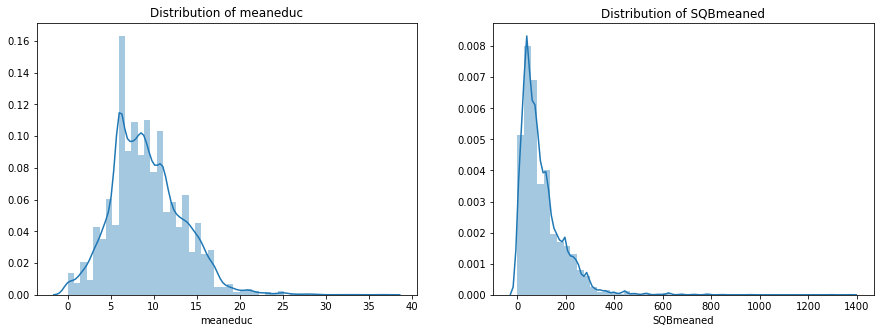

In [13]:
# Checking the distribution of the 2 variables

plt.figure (figsize = (15,5))

plt.subplot (1,2,1)
sns.distplot (income.meaneduc)
plt.title ("Distribution of meaneduc")

plt.subplot (1,2,2)
sns.distplot (income.SQBmeaned)
plt.title ("Distribution of SQBmeaned")

plt.show ()

##### The distribution of the variables are skewed. Hence, we can select median to fill the missing values.

In [14]:
# Replacing missing values in columns meaneduc and SQBmeaned with median

income.meaneduc.fillna (income.meaneduc.median (), inplace = True)
income.SQBmeaned.fillna (income.SQBmeaned.median (), inplace = True)
print ('Columns with any remaining missing values =\n', income.isna ().sum () [income.isna ().any ()])

Columns with any remaining missing values =
 v2a1       24263
rez_esc    27581
dtype: int64


##### We have already selecting these 2 columns for dropping. Hence, missing value treatment is completed.

### Step 4 - Exploratory Data Analysis

#### Step 4.1 - Exploring the object type of columns

In [15]:
# Exploring the object type of columns

income.describe (include = 'object').T

,count,unique,top,freq
Id,33413,33413,ID_5e67bf674,1
idhogar,33413,10340,fd8a6d014,13
dependency,33413,38,yes,7580
edjefe,33413,22,no,12818
edjefa,33413,22,no,22075


##### Inferences:
    1. The columns ID and idhogar have very high cardinality and hence they might now be useful in prediction.
    2. We need to check the values in the other 3 columns.

In [16]:
# Checking for values in each object column

income.select_dtypes (object)

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no
...,...,...,...,...,...
33408,ID_a065a7cad,3aa78c56b,.5,5,no
33409,ID_1a7c6953b,d237404b6,yes,6,no
33410,ID_07dbb4be2,d237404b6,yes,6,no
33411,ID_34d2ed046,d237404b6,yes,6,no


##### We can see that the columns dependency, edjefe and edjefa have mix of numerical and categorical data. We need to treat them.

In [17]:
# checking for unique values in dependency column

print ('The unique values in dependency =\n', income.dependency.unique ())

The unique values in dependency =
 ['no' '8' 'yes' '3' '.5' '.25' '2' '.66666669' '.33333334' '1.5'
 '.40000001' '.75' '1.25' '.2' '2.5' '1.2' '4' '1.3333334' '2.25'
 '.22222222' '5' '.83333331' '.80000001' '6' '3.5' '1.6666666' '.2857143'
 '1.75' '.71428573' '.16666667' '.60000002' '.375' '.14285715' '.85714287'
 '.125' '2.3333333' '7' '3.3333333']


##### From the column descriptions,
    1. Dependency is "Dependency rate, calculated = (number of members of the household younger than 19 or 
       older than 64)/(number of member of household between 19 and 64). 
    2. SQBdependency is dependency squared.
##### Inferences :
    1. The unique values in the dependency columns shows that there are no 0 and 1 values in the column
       The no/yes values might be 0/1 values.
    1. We must check the values in dependency column with dependency = (hogar_nin + hogar_mayor)/hogar_adul
    2. We must compare the values in SQBdependency and dependency columns.

In [18]:
income2 = income [(income.dependency != 'yes') & (income.dependency !='no')].copy ()
income2 = income2.astype ({'dependency' : 'float64'})
print ('Relation of the values in SQBdependency and dependency squared = ', 
       round ((income2.SQBdependency == (income2.dependency ** 2)).sum () * 100 / income2.shape [0], 2), '%')
print ('Relation of the values in Calculated dependency and dependency = ', 
       round ((((income2.hogar_nin + income2.hogar_mayor) / income2.hogar_adul) == income2.dependency).sum () \
              * 100 / income2.shape [0], 2), '%')

Relation of the values in SQBdependency and dependency squared =  73.49 %
Relation of the values in Calculated dependency and dependency =  52.58 %


In [19]:
# Comparing the no/yes values in dependency column with 0/1 values in the SQBdependency column

print (income.dependency [(income.dependency == 'yes') | (income.dependency == 'no')].value_counts ())
print (income.SQBdependency [(income.SQBdependency == 0) | (income.SQBdependency == 1)].value_counts ())

yes    7580
no     6036
Name: dependency, dtype: int64
1.0    7580
0.0    6036
Name: SQBdependency, dtype: int64


##### The count of no/yes values in dependency column is same as count of 0/1 values in the SQBdependency column. We can use this relation to replace the no/yes values

In [20]:
# Using column SQBdependency to replace yes/no values in column dependency and converting it into float type

income.dependency = income.dependency.replace ({'no' : '0', 'yes' : 1}).astype ('float64')
print ('The unique values in dependency column =\n', income.dependency.unique ())

The unique values in dependency column =
 [0.         8.         1.         3.         0.5        0.25
 2.         0.66666669 0.33333334 1.5        0.40000001 0.75
 1.25       0.2        2.5        1.2        4.         1.3333334
 2.25       0.22222222 5.         0.83333331 0.80000001 6.
 3.5        1.6666666  0.2857143  1.75       0.71428573 0.16666667
 0.60000002 0.375      0.14285715 0.85714287 0.125      2.3333333
 7.         3.3333333 ]


##### Now, let's treat the edjefe and edjefa columns

In [21]:
# checking unique values in the 2 columns

print ('The unique values in column edjefe =\n', income.edjefe.unique ())
print ('\nThe unique values in column edjefe =\n', income.edjefa.unique ())

The unique values in column edjefe =
 ['10' '12' 'no' '11' '9' '15' '4' '6' '8' '17' '7' '16' '14' '5' '21' '2'
 '19' 'yes' '3' '18' '13' '20']

The unique values in column edjefe =
 ['no' '11' '4' '10' '9' '15' '7' '14' '13' '8' '17' '6' '5' '3' '16' '19'
 'yes' '21' '12' '2' '20' '18']


##### The description of the 2 columns says that these are years of experience for males and females, yes= 1, no = 0, So, we need to replace yes with 1 and no with 0 and convert it into numeric type.

In [22]:
# Replacing yes= 1, no = 0 and converting the columns into numeric type

income.edjefe = income.edjefe.replace ({'yes' : '1', 'no' : '0'}).astype ('int64')
income.edjefa = income.edjefa.replace ({'yes' : '1', 'no' : '0'}).astype ('int64')

##### The columns id and idhogar do not add any value to the analysis, neither they can be converted to any appropriate numerical form. Hence, we can drop these columns before building the model.

In [23]:
# Adding the squared columns to the dropcols set

dropcols = dropcols.union ({'Id', 'idhogar'})
print ('Columns selected for dropping =', dropcols)

Columns selected for dropping = {'rez_esc', 'Id', 'idhogar', 'v2a1'}


#### Step 4.2 - Exploring the int and float type of columns

In [24]:
income.describe ().T

,count,mean,std,min,25%,50%,75%,max
v2a1,9150.0,172030.845574,155003.501640,0.000000,80000.000000,135000.000000,200000.000000,2852700.0
hacdor,33413.0,0.047077,0.211808,0.000000,0.000000,0.000000,0.000000,1.0
rooms,33413.0,4.955706,1.519659,1.000000,4.000000,5.000000,6.000000,15.0
hacapo,33413.0,0.027055,0.162247,0.000000,0.000000,0.000000,0.000000,1.0
v14a,33413.0,0.993326,0.081423,0.000000,1.000000,1.000000,1.000000,1.0
refrig,33413.0,0.960464,0.194868,0.000000,1.000000,1.000000,1.000000,1.0
v18q,33413.0,0.237782,0.425731,0.000000,0.000000,0.000000,0.000000,1.0
v18q1,33413.0,0.324335,0.677188,0.000000,0.000000,0.000000,0.000000,6.0
r4h1,33413.0,0.407775,0.704245,0.000000,0.000000,0.000000,1.000000,6.0
r4h2,33413.0,1.562595,1.003650,0.000000,1.000000,1.000000,2.000000,8.0


##### Inferences:
    1. Looks like many of the columns are descrete (with low cardinality) and binary type.
       Hence, it would be a good idea to do chi-squared test for these columns.
##### From the column descriptions - 
    134. SQBescolari= escolari squared
    135. SQBage, age squared
    136. SQBhogar_total, hogar_total squared
    137. SQBedjefe, edjefe squared
    138. SQBhogar_nin, hogar_nin squared
    139. SQBovercrowding, overcrowding squared
    140. SQBdependency, dependency squared
    141. SQBmeaned, square of the mean years of education of adults (>=18) in the
    household
    142. agesq= Age squared

##### These are squared columns and hence we can confirm the relation.

In [25]:
# Checking the relations of these columns with other columns in data set

print ('Relation of values in SQBescolari and escolari squared = ', 
       (income.SQBescolari == (income.escolari ** 2)).sum () * 100 / income.shape [0], '%')
print ('Relation of values in SQBage and age squared = ', 
       (income.SQBage == (income.age ** 2)).sum () * 100 / income.shape [0], '%')
print ('Relation of values in SQBhogar_total and hogar_total squared = ', 
       (income.SQBhogar_total == (income.hogar_total ** 2)).sum () * 100 / income.shape [0], '%')
print ('Relation of values in SQBedjefe and edjefe squared = ', 
       (income.SQBedjefe == (income.edjefe ** 2)).sum () * 100 / income.shape [0], '%')
print ('Relation of values in SQBhogar_nin and hogar_nin squared = ', 
       (income.SQBhogar_nin == (income.hogar_nin ** 2)).sum () * 100 / income.shape [0], '%')
print ('Relation of values in SQBovercrowding and overcrowding squared = ', 
       (income.SQBovercrowding == (income.overcrowding ** 2)).sum () * 100 / income.shape [0], '%')
print ('Relation of values in SQBdependency and dependency squared = ', 
       (income.SQBdependency == (income.dependency ** 2)).sum () * 100 / income.shape [0], '%')
print ('Relation of values in SQBmeaned and meaneduc squared = ', 
       (income.SQBmeaned == (income.meaneduc ** 2)).sum () * 100 / income.shape [0], '%')
print ('Relation of values in agesq and age squared = ', 
       (income.agesq == (income.age ** 2)).sum () * 100 / income.shape [0], '%')

Relation of values in SQBescolari and escolari squared =  100.0 %
Relation of values in SQBage and age squared =  100.0 %
Relation of values in SQBhogar_total and hogar_total squared =  100.0 %
Relation of values in SQBedjefe and edjefe squared =  100.0 %
Relation of values in SQBhogar_nin and hogar_nin squared =  100.0 %
Relation of values in SQBovercrowding and overcrowding squared =  69.36521713105678 %
Relation of values in SQBdependency and dependency squared =  84.2905455960255 %
Relation of values in SQBmeaned and meaneduc squared =  80.27414479394248 %
Relation of values in agesq and age squared =  100.0 %


##### Since, for the the columns that have 100% relation, we can remove the squared columns to avoid redundancy.
##### For SQBovercrowding, SQBdependency and SQBmeaned, we can check the correlation coefficient with their respected related columns.

In [26]:
# Checking the correlation coefficient of the columns

print ('The correlation coefficient of SQBovercrowding and overcrowding = ', 
       round (income.SQBovercrowding.corr (income.overcrowding), 3))
print ('The correlation coefficient of SQBdependency and dependency = ', 
       round (income.SQBdependency.corr (income.dependency), 3))
print ('The correlation coefficient of SQBmeaned and meanuduc = ', 
       round (income.SQBmeaned.corr (income.meaneduc), 3))

The correlation coefficient of SQBovercrowding and overcrowding =  0.879
The correlation coefficient of SQBdependency and dependency =  0.947
The correlation coefficient of SQBmeaned and meanuduc =  0.95


##### These 3 columns are also high correlated. Hence, we can remove all the squared columns.

In [27]:
# Adding the squared columns to the dropcols set

dropcols = dropcols.union ({'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 
                            'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq'})
print ('Columns selected for dropping =', dropcols)

Columns selected for dropping = {'SQBage', 'Id', 'SQBescolari', 'SQBhogar_total', 'rez_esc', 'SQBdependency', 'SQBovercrowding', 'idhogar', 'SQBhogar_nin', 'SQBmeaned', 'SQBedjefe', 'agesq', 'v2a1'}


##### There are certain interesting insights from anaylsis of column descriptions.
    1. Columns v18q and v18q1 seems to be related.
       v18q is presence or absence of tablet and v18q1 is the count of tablets.
       Hence, we can remove v18q column as it does not add any value.
    2. Similarly columns mobilephone, qmobilephone seems to be related.
       mobilephone is presence or absence of mobilephone and qmobilephone is the count of mobilephones.
       Hence, we can remove mobilephone column if such relationship is confirmed.
    3. The following columns seems to be correlated. We can check the relation.
            10. r4h1, Males younger than 12 years of age
            11. r4h2, Males 12 years of age and older
            12. r4h3, Total males in the household
            13. r4m1, Females younger than 12 years of age
            14. r4m2, Females 12 years of age and older
            15. r4m3, Total females in the household
            16. r4t1, persons younger than 12 years of age
            17. r4t2, persons 12 years of age and older
            18. r4t3, Total persons in the household
            19. tamhog, size of the household
            20. tamviv, number of persons living in the household
            23. hhsize, household size
            100. hogar_total, # of total individuals in the household
    4. We can see that the status of walls, roof and floor, level of education, house ownership
       are ordinal data not nominal, they must be treated like nominal data.
       We must combine the categories of status of walls, roof and floor, level of education, house ownership
       into single individual column representing ordinal data according to the following order:
           a. walls are bad (1) < walls are regular (2) < walls are good (3)
           b. roof is bad (1) < roof is regular (2) < roof is good (3)
           c. floor is bad (1) < floor is regular (2) < floor is good (3)
           d. no level of education (0) < incomplete primary (1) < complete primary (2) <
              incomplete academic secondary (3) < complete academic secondary (4) < 
              incomplete technical secondary (5) < complete technical secondary (6) < 
              undergraduate and higher education (7) < postgraduate higher education (8)
           e. other(assigned, borrowed) (1) < precarious (2) < rented (3) < 
              own, paying in installments (4) < own and fully paid house (5)
       We must check the sum of values in these ordinal columns before converting.
    5. The following looks like related categories.
            a. paredpreb, pareddes, paredmad, paredzinc, paredfibras, paredother are categories for
               predominant material on the outside wall.
            b. pisomoscer, pisocemento, pisoother, pisonatur, pisonotiene, pisomadera are categories for
               predominant material on the floor.
            c. techozinc, techoentrepiso, techocane, techootro are categories for
               predominant material on the roof.
            d. abastaguadentro, abastaguafuera, abastaguano are categories for water provision.
            e. public, planpri, noelec, coopele are categories for electricity supply.
            f. sanitario1, sanitario2, sanitario3, sanitario5, sanitario6 are categories for 
               toilet connection.
            g. energcocinar1, energcocinar2, energcocinar3, energcocinar4 are categories for 
               source of energy for cooking.
            h. elimbasu1, elimbasu2, elimbasu3, elimbasu4, elimbasu5, elimbasu6 are categories for 
               rubbish disposal.
            i. male, female are categories for gender.
            j. estadocivil1, estadocivil2, estadocivil3, estadocivil4, estadocivil5, estadocivil6, 
               estadocivil7 are categories for marital status.
            k. parentesco1, parentesco2, parentesco3, parentesco4, parentesco5, parentesco6, parentesco7, 
               parentesco8, parentesco9, parentesco10, parentesco11, parentesco12 are categories for 
               relationship between house members.
            l. lugar1, lugar2, lugar3, lugar4, lugar5, lugar6, are categories for different regions.
            m. area1, area2 are are categories for areas (rural and urban).
       We can check the relations and remove the extra category if found.

In [28]:
# checking relationship between mobilephone and qmobilephone

pd.crosstab (income.mobilephone, income.qmobilephone)

qmobilephone,0,1,2,3,4,5,6,7,8,9,10,11
mobilephone,,,,,,,,,,,,
0,765,0,0,0,0,0,0,0,0,0,0,0
1,0,4259,10733,7990,5642,2671,845,209,168,78,42,11


##### The cross table shows that wherever mobilephone is 0 qmobilephone is also 0. And for all values of qmobilephone > 0, mobilephone = 1. This confirms the relationship and hence we can remove the mobilephone column.

In [29]:
# r4h1, r4h2, r4h3 seems to be related
# r4m1, r4m2, r4m3 seems to be related
# r4t1, r4t2, r4t3 seems to be related

print ('The relation of values in the columns r4h1, r4h2, r4h3 = ', 
       ((income.r4h1 + income.r4h2) == income.r4h3).sum () * 100 / income.shape [0], '%')
print ('The relation of values in the columns r4m1, r4m2, r4m3 = ', 
       ((income.r4m1 + income.r4m2) == income.r4m3).sum () * 100 / income.shape [0], '%')
print ('The relation of values in the columns r4t1, r4t2, r4t3 = ', 
       ((income.r4t1 + income.r4t2) == income.r4t3).sum () * 100 / income.shape [0], '%')

The relation of values in the columns r4h1, r4h2, r4h3 =  100.0 %
The relation of values in the columns r4m1, r4m2, r4m3 =  100.0 %
The relation of values in the columns r4t1, r4t2, r4t3 =  100.0 %


In [30]:
# r4h3, r4m3 are total males and females in the household. That must be same as r4t3
# r4h1, r4m1 are total males and females under 12 years. That must be equal to r4t1
# r4t3, tamhog, tamviv, hhsize, hogar_total must all be same

print ('The relation of values in the columns r4h3, r4m3, r4t3 = ', 
       ((income.r4h3 + income.r4m3) == income.r4t3).sum () * 100 / income.shape [0], '%\n')
print ('The relation of values in the columns r4h1, r4m1, r4t1 = ', 
       ((income.r4h1 + income.r4m1) == income.r4t1).sum () * 100 / income.shape [0], '%\n')
income [['r4t3', 'tamhog', 'tamviv', 'hhsize', 'hogar_total']].corr ()

The relation of values in the columns r4h3, r4m3, r4t3 =  100.0 %

The relation of values in the columns r4h1, r4m1, r4t1 =  100.0 %



,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998856,0.924693,0.998856,0.998856
tamhog,0.998856,1.000000,0.923807,1.000000,1.000000
tamviv,0.924693,0.923807,1.000000,0.923807,0.923807
hhsize,0.998856,1.000000,0.923807,1.000000,1.000000
hogar_total,0.998856,1.000000,0.923807,1.000000,1.000000


##### As expected the columns are all related with some deviation due to incorrect data probably. The columns r4h1 (total males under 12 years), r4t1 (total people under 12 years), r4h3 (total males in the household), r4t3 (total people in the household) can explain all the other columns as below.
    1. Total people < 12 years - Total males < 12 years = Total females < 12 years
    2. Total males - Total males < 12 years = Total males >= 12 years
    3. Total people - Total males = Total females
    4. Total females - Total females < 12 years = Total females >= 12 years
    5. Total people - Total people < 12 years = Total people >= 12 years
    Hence, we can drop all other columns to avoid redundancy.

In [31]:
# Adding the columns to the dropcols set

dropcols = dropcols.union ({'v18q', 'r4h2', 'r4m1', 'r4m2', 'r4m3', 'r4t2', 'tamhog', 'tamviv',
                            'hhsize', 'hogar_total', 'mobilephone'})
print ('Columns selected for dropping =', dropcols)

Columns selected for dropping = {'SQBage', 'hhsize', 'tamhog', 'r4m3', 'idhogar', 'SQBhogar_nin', 'SQBedjefe', 'SQBmeaned', 'v2a1', 'hogar_total', 'Id', 'r4m2', 'SQBescolari', 'v18q', 'SQBhogar_total', 'rez_esc', 'SQBdependency', 'tamviv', 'SQBovercrowding', 'r4h2', 'r4t2', 'mobilephone', 'agesq', 'r4m1'}


In [32]:
# condition of walls
print ('Is there any row for condition of walls with the sum not equal to 1 ?\n', 
       (income [['epared1', 'epared2', 'epared3']].sum (axis = 1) != 1).any ())

# condition of roof
print ('Is there any row for condition of roof with the sum not equal to 1 ?\n', 
       (income [['etecho1', 'etecho2', 'etecho3']].sum (axis = 1) != 1).any ())

# condition of floor
print ('Is there any row for condition of floor with the sum not equal to 1 ?\n', 
       (income [['eviv1', 'eviv2', 'eviv3']].sum (axis = 1) != 1).any ())

# level of education
print ('Is there any row for level of education with the sum not equal to 1 ?\n', 
       (income [['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5',\
                 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']].sum (axis = 1) != 1).any ())

# house ownership
print ('Is there any row for house ownership with the sum not equal to 1 ?\n', 
       (income [['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']].sum (axis = 1) != 1).any ())

Is there any row for condition of walls with the sum not equal to 1 ?
 False
Is there any row for condition of roof with the sum not equal to 1 ?
 False
Is there any row for condition of floor with the sum not equal to 1 ?
 False
Is there any row for level of education with the sum not equal to 1 ?
 True
Is there any row for house ownership with the sum not equal to 1 ?
 False


##### There might be some missing or extra values in level of education.

In [33]:
# For level of education, let's understand if the values are missing or extra

print ('Sum of extra values =', 
       (income [['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6',\
                'instlevel7', 'instlevel8', 'instlevel9']].sum (axis = 1) > 1).sum (), 
       '\nSum of missing values =', 
       (income [['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6',\
                'instlevel7', 'instlevel8', 'instlevel9']].sum (axis = 1) < 1).sum ())

Sum of extra values = 0 
Sum of missing values = 8


##### There are some missing values which we can fill using category with the maximum frequency

In [34]:
# Finding the category with maximum frequency

print ('The frequency of categories in education level are:\n', 
       income [['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6',\
                'instlevel7', 'instlevel8', 'instlevel9']].sum ().sort_values (ascending = False))

The frequency of categories in education level are:
 instlevel3    6951
instlevel4    6180
instlevel2    5784
instlevel8    4768
instlevel1    4399
instlevel5    3769
instlevel6     596
instlevel7     480
instlevel9     478
dtype: int64


##### instlevel3 has the maximum frequency. So, we can replace missing values using it.

In [35]:
# Creating ordered status of walls column
income.epared2 = income.epared2.replace ({1 : 2})
income.epared3 = income.epared3.replace ({1 : 3})
income ['epared'] = income.epared1 + income.epared2 + income.epared3
income.drop (columns = ['epared1', 'epared2', 'epared3'], inplace = True)

# Creating ordered status of roof column
income.etecho2 = income.etecho2.replace ({1 : 2})
income.etecho3 = income.etecho3.replace ({1 : 3})
income ['etecho'] = income.etecho1 + income.etecho2 + income.etecho3
income.drop (columns = ['etecho1', 'etecho2', 'etecho3'], inplace = True)

# Creating ordered status of floor column
income.eviv2 = income.eviv2.replace ({1 : 2})
income.eviv3 = income.eviv3.replace ({1 : 3})
income ['eviv'] = income.eviv1 + income.eviv2 + income.eviv3
income.drop (columns = ['eviv1', 'eviv2', 'eviv3'], inplace = True)

# Creating ordered household ownership
income.tipovivi1 = income.tipovivi1.replace ({1 : 5})
income.tipovivi2 = income.tipovivi2.replace ({1 : 4})
income.tipovivi3 = income.tipovivi3.replace ({1 : 3})
income.tipovivi4 = income.tipovivi4.replace ({1 : 2})
income ['tipovivi'] = income.tipovivi1 + income.tipovivi2 + income.tipovivi3 + income.tipovivi4 + income.tipovivi5
income.drop (columns = ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5'], inplace = True)

# Replacing the missing values in the selected column of the education level
instlevels = ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', \
              'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']
income.loc [income [instlevels].sum (axis = 1) < 1, 'instlevel3'] = 1

# Creating ordered level of education column
income.loc [ : ,'instlevel1'] = 0
income.instlevel3 = income.instlevel3.replace ({1 : 2})
income.instlevel4 = income.instlevel4.replace ({1 : 3})
income.instlevel5 = income.instlevel5.replace ({1 : 4})
income.instlevel6 = income.instlevel6.replace ({1 : 5})
income.instlevel7 = income.instlevel7.replace ({1 : 6})
income.instlevel8 = income.instlevel8.replace ({1 : 7})
income.instlevel9 = income.instlevel9.replace ({1 : 8})
income ['instlevel'] = income.instlevel1 + income.instlevel2 + income.instlevel3 + income.instlevel4 + \
                        income.instlevel5 + income.instlevel6 + income.instlevel7 + income.instlevel8 +\
                        income.instlevel9
income.drop (columns = ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6',\
                        'instlevel7', 'instlevel8', 'instlevel9'], inplace = True)

In [36]:
# Checking for simlar categories:

# predominant material on the outside wall
print ('Is there any row with the sum not equal to 1 ?\n', 
       (income [['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', \
          'paredfibras', 'paredother']].sum (axis = 1) != 1).any ())

# predominant material on the floor
print ('Is there any row for predominant material on the floor with the sum not equal to 1 ?\n', 
       (income [['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']]\
        .sum (axis = 1) != 1).any ())

# predominant material on the roof
print ('Is there any row for predominant material on the roof with the sum not equal to 1 ?\n', 
       (income [['techozinc', 'techoentrepiso', 'techocane', 'techootro']].sum (axis = 1) != 1).any ())

# water provision
print ('Is there any row for water provision with the sum not equal to 1 ?\n', 
       (income [['abastaguadentro', 'abastaguafuera', 'abastaguano']].sum (axis = 1) != 1).any ())

# electricity
print ('Is there any row for electricity with the sum not equal to 1 ?\n', 
       (income [['public', 'planpri', 'noelec', 'coopele']].sum (axis = 1) != 1).any ())

# toilet
print ('Is there any row for toilet with the sum not equal to 1 ?\n', 
       (income [['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']]\
        .sum (axis = 1) != 1).any ())

# main source of energy used for cooking
print ('Is there any row for main source of energy used for cooking with the sum not equal to 1 ?\n', 
       (income [['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']].sum (axis = 1) != 1).any ())

# rubbish disposal
print ('Is there any row for rubbish disposal with the sum not equal to 1 ?\n', 
       (income [['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']].\
        sum (axis = 1) != 1).any ())

# gender
print ('Is there any row for condition of gender with the sum not equal to 1 ?\n', 
       (income [['male', 'female']].sum (axis = 1) != 1).any ())

# marital status
print ('Is there any row for marital status with the sum not equal to 1 ?\n', 
       (income [['estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5',\
                 'estadocivil6', 'estadocivil7']].sum (axis = 1) != 1).any ())

# Relationship between members of house
print ('Is there any row for relationship with the sum not equal to 1 ?\n', 
       (income [['parentesco1', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5',\
                 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10',\
                 'parentesco11', 'parentesco12']].sum (axis = 1) != 1).any ())

# region
print ('Is there any row for region with the sum not equal to 1 ?\n', 
       (income [['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']].sum (axis = 1) != 1).any ())

# area
print ('Is there any row for area with the sum not equal to 1 ?\n', 
       (income [['area1', 'area2']].sum (axis = 1) != 1).any ())

Is there any row with the sum not equal to 1 ?
 False
Is there any row for predominant material on the floor with the sum not equal to 1 ?
 False
Is there any row for predominant material on the roof with the sum not equal to 1 ?
 True
Is there any row for water provision with the sum not equal to 1 ?
 False
Is there any row for electricity with the sum not equal to 1 ?
 True
Is there any row for toilet with the sum not equal to 1 ?
 False
Is there any row for main source of energy used for cooking with the sum not equal to 1 ?
 False
Is there any row for rubbish disposal with the sum not equal to 1 ?
 False
Is there any row for condition of gender with the sum not equal to 1 ?
 False
Is there any row for marital status with the sum not equal to 1 ?
 False
Is there any row for relationship with the sum not equal to 1 ?
 False
Is there any row for region with the sum not equal to 1 ?
 False
Is there any row for area with the sum not equal to 1 ?
 False


##### Inferences: 
    1. Except from predominant material on the roof and electricity, all other categorical variables
       have one dependent column which we can remove.
    2. We can drop the columns paredother, pisoother, abastaguano, sanitario1, energcocinar1, 
       elimbasu6, female, estadocivil1, parentesco12, lugar1, area1.

In [37]:
# Adding the columns to the dropcols set

dropcols = dropcols.union ({'paredother', 'pisoother', 'abastaguano', 'sanitario1', 'energcocinar1', 
                            'elimbasu6', 'female', 'estadocivil1', 'parentesco12', 'lugar1', 'area1'})
print ('Columns selected for dropping =', dropcols)

Columns selected for dropping = {'SQBage', 'hhsize', 'sanitario1', 'tamhog', 'paredother', 'r4m3', 'idhogar', 'SQBhogar_nin', 'energcocinar1', 'lugar1', 'SQBedjefe', 'SQBmeaned', 'v2a1', 'hogar_total', 'Id', 'r4m2', 'parentesco12', 'SQBescolari', 'estadocivil1', 'v18q', 'pisoother', 'elimbasu6', 'SQBhogar_total', 'female', 'rez_esc', 'SQBdependency', 'tamviv', 'SQBovercrowding', 'abastaguano', 'area1', 'r4h2', 'r4t2', 'mobilephone', 'agesq', 'r4m1'}


#### Step 4.3 - Exploring the target variable

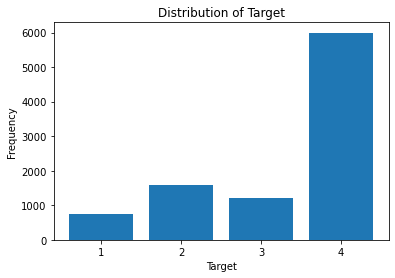

In [38]:
# Exploring the target variables of train data only as we have Target only in train data

target_counts = income.iloc [train_rows].Target.value_counts ()
plt.bar (target_counts.index, target_counts.values)
plt.title ('Distribution of Target')
plt.xlabel ('Target')
plt.ylabel ('Frequency')
plt.xticks (target_counts.index)
plt.show ()

##### Inferences:
    1. The frequency of class 4 i.e. non vulnerable households is almost 3 times the other classes.
    2. This shows imbalanced classes in the target variable (poverty levels) and hence there is bias in the data.
    3. We need to treat the imbalanced classes while building the model.

#### Step 4.4 - Exploring the numerical variables (descrete and continuous)

In [39]:
# considering the columns having > 30 unique values as numerical columns

num_col = income.drop (columns = dropcols).columns [income.drop (columns = dropcols).nunique () > 30]
print ('The numerical columns are: ', num_col)

The numerical columns are:  Index(['dependency', 'meaneduc', 'overcrowding', 'age'], dtype='object')


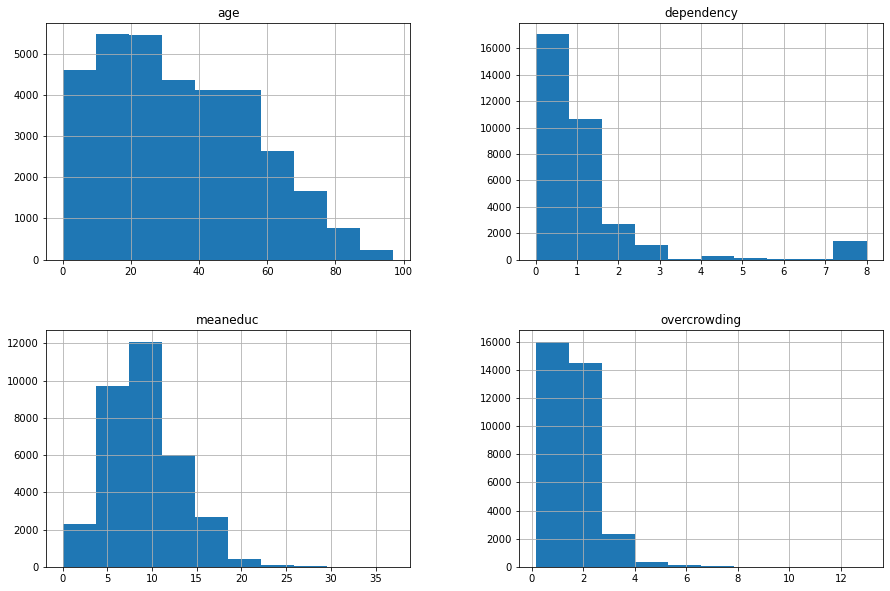

In [40]:
# Distributions of numerical columns

income [num_col].hist (figsize = (15,10));

##### Inferences:
    1. All the above distributions show that these columns are highly skewed which again shows bias in the data.
    2. We must transform the columns to reduce the skewness before model building.
    3. We also observe that apart from overcrowding, all other columns have some values = 0.
       Hence, logarithmic transformation is not possible for these columns. 
    4. We can try for square root or cubic transformations for these columns.

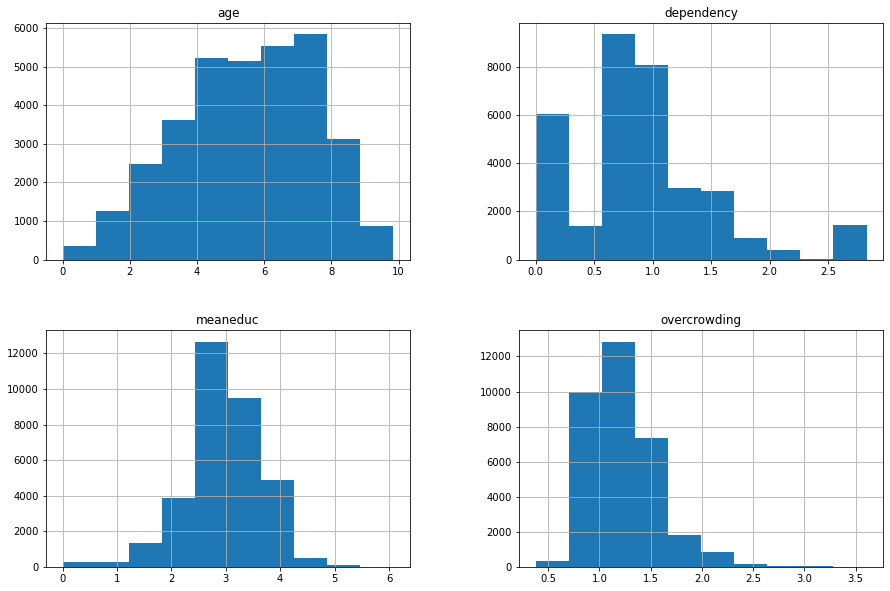

In [41]:
# Square root transformations of numerical columns

fig, ax = plt.subplots (nrows = 2, ncols = 2, figsize = (15,10))
np.sqrt (income [num_col]).hist (ax = ax);

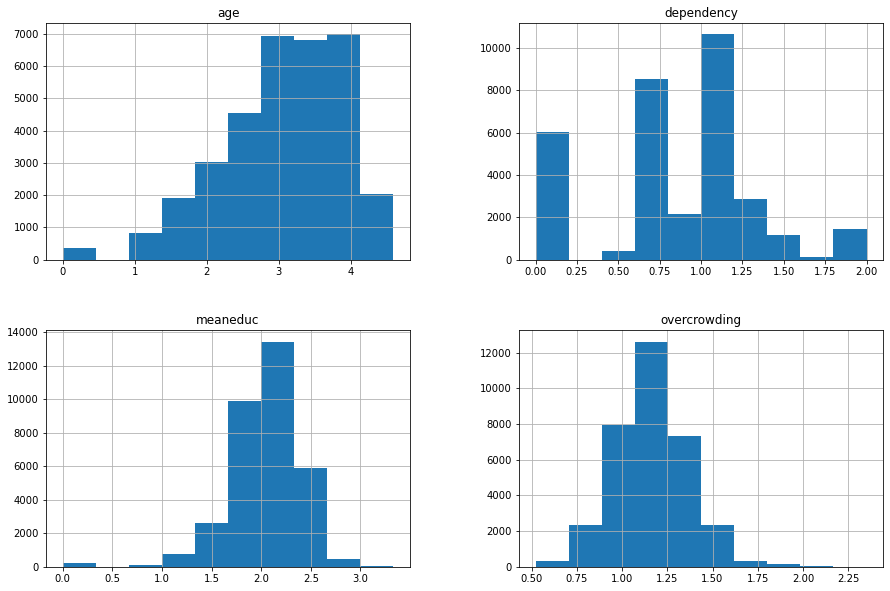

In [42]:
# Cube root transformations of numerical columns

fig, ax = plt.subplots (nrows = 2, ncols = 2, figsize = (15,10))
np.cbrt (income [num_col]).hist (ax = ax);

##### Inferences:
    1. Square root transformations of meaneduc and age are closer to normal distributions.
    2. Cubic transformations of overcrowding and dependency are closer to normal distributions.
    3. We can do square root transformations of meaneduc and age, where as cubic transformations 
       of overcrowding and dependency.

In [43]:
# Performing required transformations

income [['meaneduc', 'age']] = np.sqrt (income [['meaneduc', 'age']])
income [['overcrowding', 'dependency']] = np.cbrt (income [['overcrowding', 'dependency']])
income [['meaneduc', 'age', 'overcrowding', 'dependency']].head ()

,meaneduc,age,overcrowding,dependency
0,3.162278,6.557439,1.000000,0.0
1,3.464102,8.185353,1.000000,2.0
2,3.316625,9.591663,0.793701,2.0
3,3.316625,4.123106,1.100642,1.0
4,3.316625,6.082763,1.100642,1.0


#### Step 4.5 - Exploring the relationship of numerical variables (descrete and continuous) with the target variable.

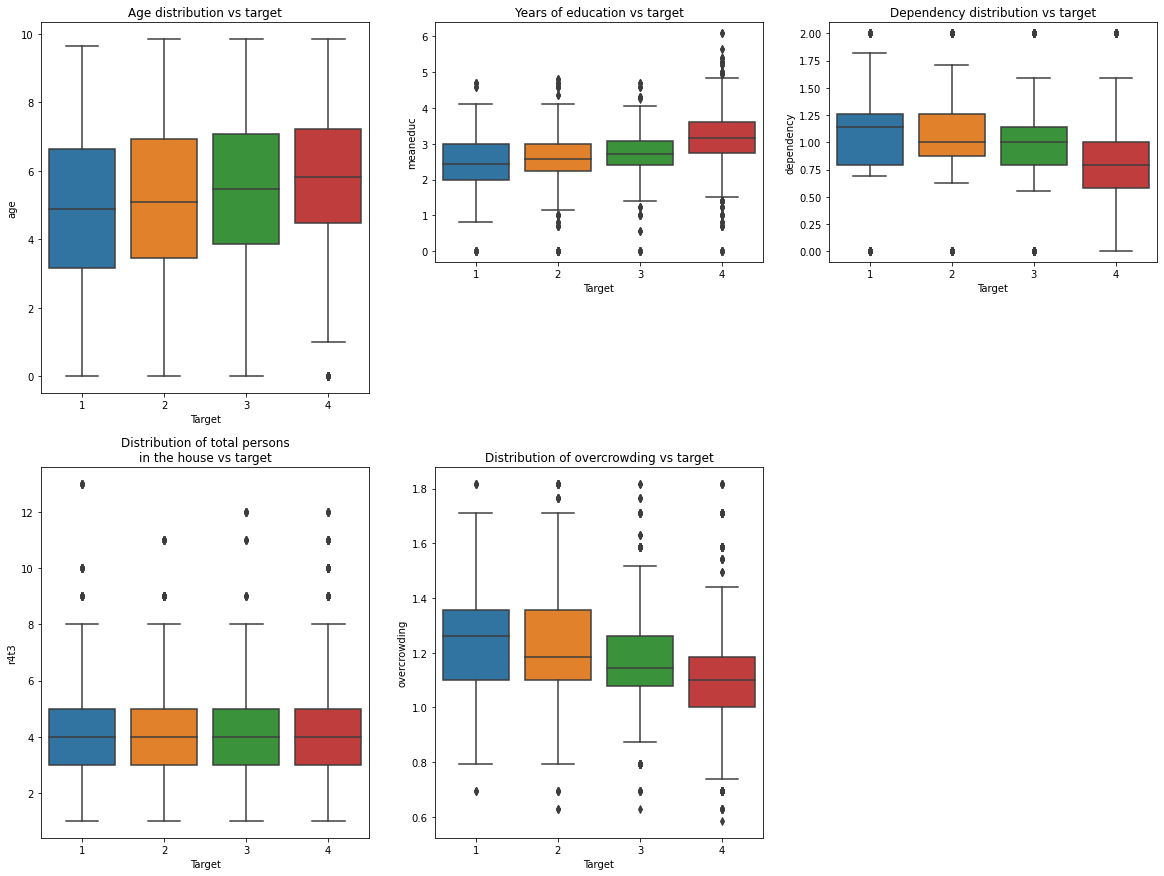

In [44]:
plt.figure (figsize = (20,15))

# Distribution of Age with Target
plt.subplot (231)
sns.boxplot (income.iloc[train_rows].Target, income.iloc [train_rows].age)
plt.title ('Age distribution vs target')

# Distribution of years of education for adults with Target
plt.subplot (332)
sns.boxplot (income.iloc[train_rows].Target, income.iloc[train_rows].meaneduc)
plt.title ('Years of education vs target')

# Distribution of dependency with Target
plt.subplot (333)
sns.boxplot (income.iloc[train_rows].Target, income.iloc[train_rows].dependency)
plt.title ('Dependency distribution vs target')

# Distribution of Total Persons in the house with Target
plt.subplot (234)
sns.boxplot (income.iloc[train_rows].Target, income.iloc[train_rows].r4t3)
plt.title ('Distribution of total persons\nin the house vs target')

# Distribution of Overcrowding with Target
plt.subplot (235)
sns.boxplot (income.iloc[train_rows].Target, income.iloc[train_rows].overcrowding)
plt.title ('Distribution of overcrowding vs target')

plt.show ()

##### Inferences:
    1. The above variables doesn't have high discriminating power (specially between classes 1, 2, 3)
    2. More is the years of education, higher is the chances of being non-vulnerable househould.
       Though it is hard to describe for other classes.
    3. Lesser is the dependency and overcrowding, higher is the chances of being non-vulnerable househould.
       Though it is hard to describe for other classes.

#### Step 4.6 - Exploring the relationship of some categorical variables with the target variable.

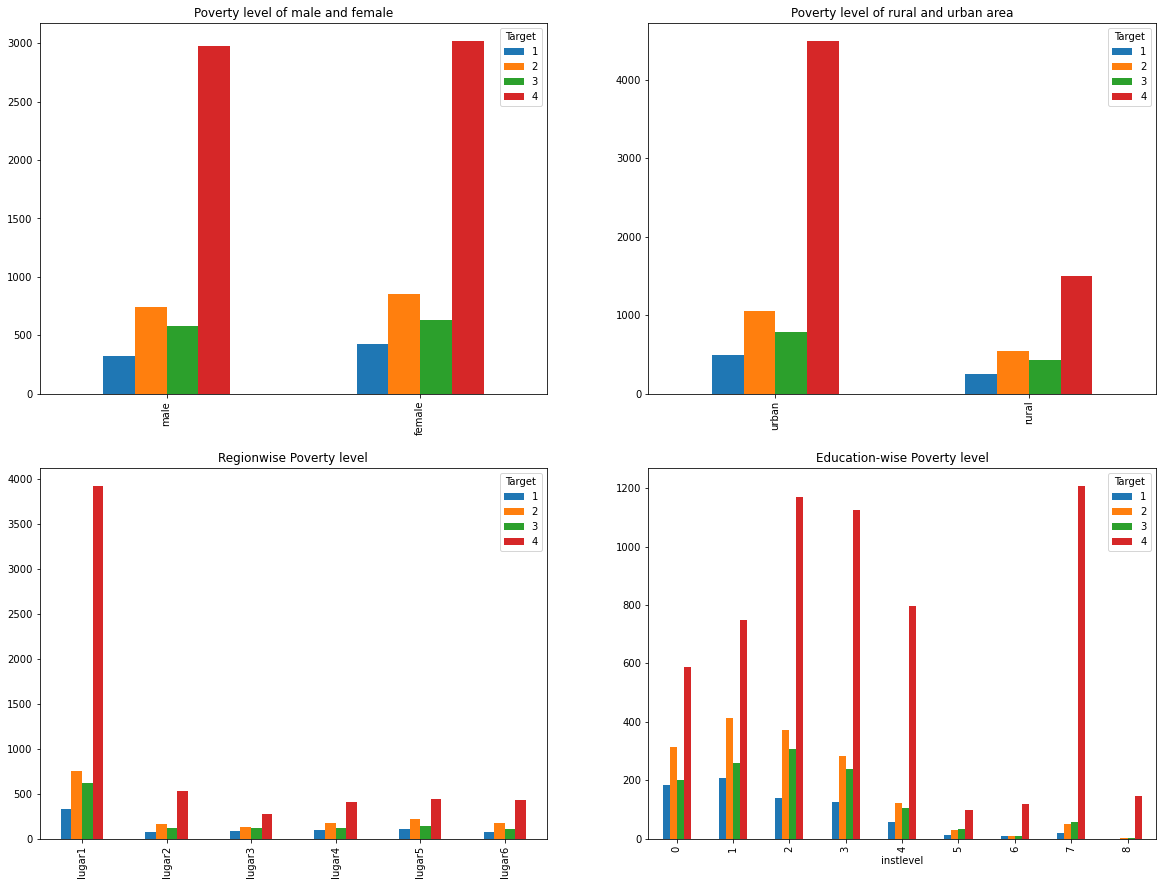

In [45]:
fig, ax = plt.subplots (nrows=2, ncols=2, figsize = (20,15))

# Poverty level of male vs female

gender_pov = income.iloc[train_rows].groupby ('Target').agg ({'male' : sum, 'female' : sum}).T
gender_pov.plot (kind = 'bar', ax = ax [0, 0])
ax [0, 0].set_title ('Poverty level of male and female')

# Poverty Level of rural vs urban

area_pov = income.iloc[train_rows].groupby ('Target').agg ({'area1' : sum, 'area2' : sum}).T
area_pov.rename (index = {'area1' : 'urban', 'area2' : 'rural'}, inplace = True)
area_pov.plot (kind = 'bar', ax = ax [0, 1])
ax [0, 1].set_title ('Poverty level of rural and urban area')

# Region-wise poverty level
region_pov = income.iloc[train_rows].groupby ('Target').agg ({'lugar1' : sum, 'lugar2' : sum, 
                                                              'lugar3' : sum, 'lugar4' : sum,
                                                              'lugar5' : sum, 'lugar6' : sum}).T
region_pov.plot (kind = 'bar', ax = ax [1, 0])
ax [1, 0].set_title ('Regionwise Poverty level')

# Education-wise poverty level
edu_pov = pd.crosstab (income.iloc[train_rows].instlevel, income.iloc[train_rows].Target)
edu_pov.plot (kind = 'bar', ax = ax [1, 1])
ax [1, 1].set_title ('Education-wise Poverty level');

##### Inferences:
    1. Though, its hard to visualize due to imbalanced classes, but it is still evident that
       as the education level increases, more people fall in the category of non-vulnerable househould.
    2. We can use class weights and then explore these variables for better inferences.

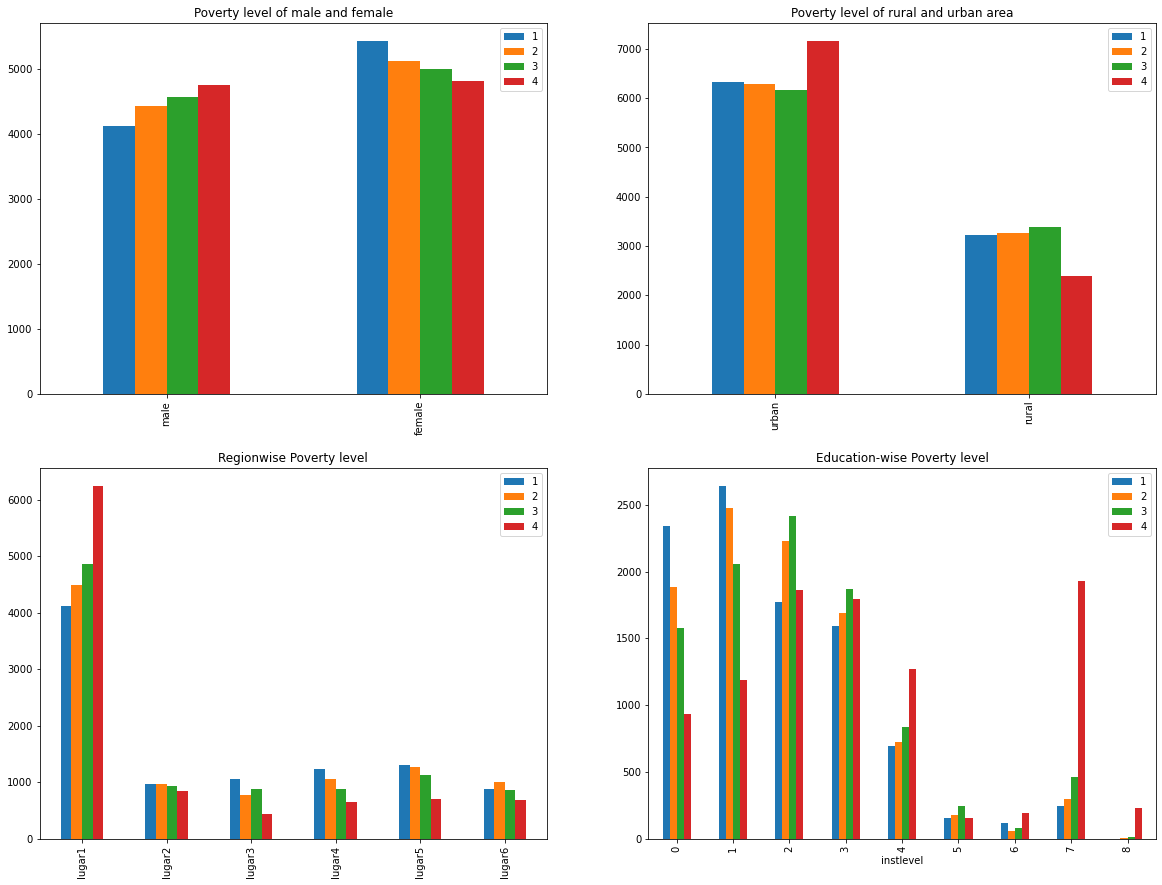

In [46]:
# Defining class weights

weights = income.iloc[train_rows].shape [0] / income.iloc[train_rows].Target.value_counts ()

fig, ax = plt.subplots (nrows=2, ncols=2, figsize = (20,15))

# Poverty level of male vs female

gender_pov = income.iloc[train_rows].groupby ('Target').agg ({'male' : sum, 
                                                              'female' : sum}).T * weights
gender_pov.plot (kind = 'bar', ax = ax [0, 0])
ax [0, 0].set_title ('Poverty level of male and female')

# Poverty Level of rural vs urban

area_pov = income.iloc[train_rows].groupby ('Target').agg ({'area1' : sum, 
                                                            'area2' : sum}).T * weights
area_pov.rename (index = {'area1' : 'urban', 'area2' : 'rural'}, inplace = True)
area_pov.plot (kind = 'bar', ax = ax [0, 1])
ax [0, 1].set_title ('Poverty level of rural and urban area')

# Region-wise poverty level

region_pov = income.iloc[train_rows].groupby ('Target').agg ({'lugar1' : sum, 'lugar2' : sum, 
                                                              'lugar3' : sum, 'lugar4' : sum, 
                                                              'lugar5' : sum, 'lugar6' : sum}).T * weights
region_pov.plot (kind = 'bar', ax = ax [1, 0])
ax [1, 0].set_title ('Regionwise Poverty level')

# Education-wise poverty level

edu_pov = pd.crosstab (income.iloc[train_rows].instlevel, income.iloc[train_rows].Target) * weights
edu_pov.plot (kind = 'bar', ax = ax [1, 1])
ax [1, 1].set_title ('Education-wise Poverty level');

##### Inferences: 
    1. Females are more affected by poverty than males as we can see higher counts of 1 and 2 classes
       compared to 3 and 4 in females.
    2. More proportion of people are affected by poverty in rural areas as compared to urban areas.
    3. Central region is least affected by poverty compared to other regions.
    4. More is the education level, lesser poverty stricken they are.
Adding class weights has helped in finding better inferences from the graphs.

#### Step 4.7 - Other explorations

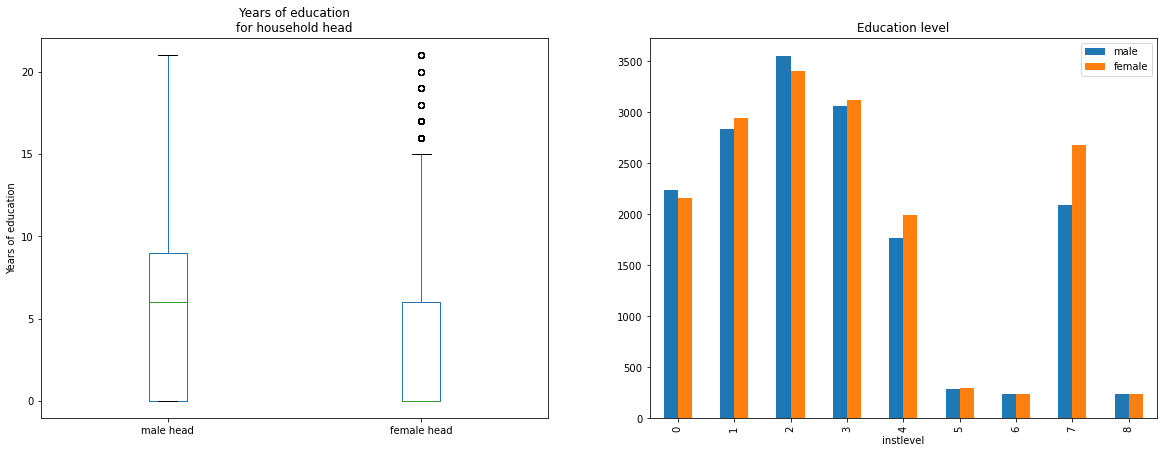

In [47]:
fig, ax = plt.subplots (nrows=1, ncols=2, figsize = (20,7))

# years of education of male head vs female head

income [['edjefe', 'edjefa']].plot (kind = 'box', ax = ax [0]);
ax [0].set_title ('Years of education\nfor household head')
ax [0].set_xticklabels (['male head', 'female head'])
ax [0].set_ylabel ('Years of education')

# education levels of males head vs females

edu_level = income.groupby ('instlevel').agg ({'male' : sum, 'female' : sum})
edu_level.plot (kind = 'bar', ax = ax [1]);
ax [1].set_title ('Education level');

##### Inferences:
    1. Years of education for male head of household is greater than the female head of household.
    2. Education level for males vs females is appoximately similar.

In [48]:
# Check whether all members of the house have the same poverty level

house_pov = income.iloc[train_rows].groupby ('idhogar').agg ({'Target' : 'nunique'}).Target
print ('Number of household having all members at same poverty level =',
       (house_pov == 1).sum ())
print ('\nNumber of household having some family members at different poverty levels =',
       (house_pov > 1).sum ())
print ('\nList of households having some family members at different poverty levels =\n',
       house_pov [house_pov > 1].index)

Number of household having all members at same poverty level = 2903

Number of household having some family members at different poverty levels = 85

List of households having some family members at different poverty levels =
 Index(['0172ab1d9', '03f4e5f4d', '0511912b6', '078a0b6e2', '09e25d616',
       '0f3e65c83', '0f9494d3a', '15a891635', '17fb04a62', '18832b840',
       '26b3a0f41', '288579c97', '28893b5e7', '2c9872b82', '2cb443214',
       '309fb7246', '30a70901d', '3c6973219', '3c73c107f', '3df651058',
       '3fe29a56b', '410194c8b', '417865404', '42ec8bef5', '43b9c83e5',
       '44f219a16', '46af47063', '4b6077882', '4c2dba109', '4dc11e11f',
       '4e19bd549', '50e064ee8', '513adb616', '54118d5d9', '55a662731',
       '564eab113', '594d3eb27', '5c3f7725d', '5c6f32bbc', '5e9329fc6',
       '614b48fb7', '636330516', '654ef7612', '67ad49822', '6833ac5dc',
       '694a0cbf4', '6a389f3de', '6bcf799cf', '6c543442a', '71cd52a80',
       '73d85d05d', '7ad269eef', '7c57f8237', '7e9d58

##### We can see that there are 85 households having some family members at different poverty levels.

In [49]:
# Check if there is a house without a family head.

print ('**************************** For train data ****************************')
house_head_train = income.iloc[train_rows].groupby ('idhogar').agg ({'parentesco1' : sum}).parentesco1
print ('\nNumber of houses without a family head =', (house_head_train == 0).sum ())
print ('\nList of houses without a family head =\n', house_head_train [house_head_train == 0].index)
print ('\nIs there any house with more than 1 family head ?   ', (house_head_train > 1).any ())

print ('\n\n**************************** For test data ****************************')
house_head_test = income.iloc[test_rows].groupby ('idhogar').agg ({'parentesco1' : sum}).parentesco1
print ('\nNumber of houses without a family head =', (house_head_test == 0).sum ())
print ('\nList of houses without a family head =\n', house_head_test [house_head_test == 0].index)
print ('\nIs there any house with more than 1 family head ?   ', (house_head_test > 1).any ())

**************************** For train data ****************************

Number of houses without a family head = 15

List of houses without a family head =
 Index(['03c6bdf85', '09b195e7a', '1367ab31d', '1bc617b23', '374ca5a19',
       '61c10e099', '6b1b2405f', '896fe6d3e', 'a0812ef17', 'ad687ad89',
       'b1f4d89d7', 'bfd5067c2', 'c0c8a5013', 'd363d9183', 'f2bfa75c4'],
      dtype='object', name='idhogar')

Is there any house with more than 1 family head ?    False


**************************** For test data ****************************

Number of houses without a family head = 18

List of houses without a family head =
 Index(['0e2a3453d', '198fc274a', '2dc45d484', '5a667591a', '676750a21',
       '91aff0a8e', '9d874b0d6', 'b115b4536', 'b59f5b526', 'ce6154327',
       'd14b3e03a', 'd678c45ad', 'df06e01c6', 'e3f69768c', 'e4df1caaf',
       'f2fd28dbb', 'f6d6fad32', 'fc6c8d241'],
      dtype='object', name='idhogar')

Is there any house with more than 1 family head ?    False


##### Inferences:
    1. There are 15 houses without a family head in the train data and 18 houses in the test data.
    2. For the houses with different poverty levels, we need to set the poverty level of all members 
       same family head.
    3. Before that we need to check if there is households without a family head but with different 
       poverty levels of members.

In [50]:
# checking if there is a house at different poverty level but without the family head

house_nohead_pov = house_pov [house_head_train [house_head_train == 0].index]
print ('\nNumber of household (without family head) having members at different poverty levels =',
       (house_nohead_pov > 1).sum ())


Number of household (without family head) having members at different poverty levels = 0


###### Now that we know that all households at different poverty level have a head, we can set the poverty levels of all members same as family head.

In [51]:
# Setting poverty level of all members of the household same as family head

for house in house_pov [house_pov > 1].index :
    pov_level = income.loc [(income.idhogar == house) | (income.parentesco1 == 1), 'Target'].values [0]
    income.loc [income.idhogar == house, 'Target'] = pov_level

In [52]:
# Finding significance of features of all categorical variables using chi square test

income_drop = income.drop (columns = dropcols)
skb = SelectKBest (score_func = chi2, k = 'all', )
skb.fit (income_drop.loc [ train_rows , income_drop.nunique () <= 20 ], 
         income_drop.iloc[train_rows].Target)

display (pd.DataFrame ({'columns' : income_drop.columns [income_drop.nunique () <= 20],
                        'p-values' : skb.pvalues_,
                        'significance at 0.1' : np.where (skb.pvalues_ > 0.1, 'non-significant', 'significant')}))

print ('Number of non-significant columns =', (skb.pvalues_ > 0.1).sum ())

<ipython-input-52-cb56f7e9b5a9>:10: RuntimeWarning: invalid value encountered in greater
  'significance at 0.1' : np.where (skb.pvalues_ > 0.1, 'non-significant', 'significant')}))


,columns,p-values,significance at 0.1
0,hacdor,1.522348e-88,significant
1,rooms,3.346537e-43,significant
2,hacapo,8.367671e-46,significant
3,v14a,9.659823e-01,non-significant
4,refrig,1.362546e-01,non-significant
5,v18q1,2.953532e-128,significant
6,r4h1,1.240270e-137,significant
7,r4h3,5.714381e-06,significant
8,r4t1,9.923714e-282,significant
9,r4t3,1.540133e-32,significant


Number of non-significant columns = 15


<ipython-input-52-cb56f7e9b5a9>:12: RuntimeWarning: invalid value encountered in greater
  print ('Number of non-significant columns =', (skb.pvalues_ > 0.1).sum ())


##### Though there are some non-significant columns, but since we would like to use Random Forest Classifier for this classification problem, we can identify feature importance using random forest's in-built feature importance method.

### Step 5 - Building the model

In [53]:
# Separating the train and test data set

income_train = income.iloc [train_rows].copy ()
income_test = income.iloc [test_rows].copy ()

In [54]:
# Defining class weights to balance the classes

weights = dict (income_train.shape [0] / (income_train.Target.value_counts () * income_train.Target.nunique ()))
weights

{4: 0.3789452815226011,
 2: 1.6626652748782185,
 3: 2.148606115107914,
 1: 3.3986486486486487}

In [55]:
# Defining X and y variables

dropcols = dropcols.union ({'Target'})
X = income_train.drop (columns = dropcols)
y = income_train.Target

In [56]:
# Building the model

rf = RandomForestClassifier (n_estimators = 100, 
                             oob_score = True, 
                             max_features = 'sqrt', 
                             class_weight = weights,
                             random_state = 12)
rf.fit (X, y)

print ('Training accuracy score =', rf.score (X,y))
print ('Out of Box (OOB) score =', rf.oob_score_)

Training accuracy score = 1.0
Out of Box (OOB) score = 0.9532280004185414


### Step 6 - Model Evaluation

In [57]:
skf = StratifiedKFold (n_splits=5, 
                       shuffle = True, 
                       random_state = 12)
count = 0
def clf_report (y_true, y_pred) :
    global count
    count += 1
    
    if ((count % 2) != 0) :
        fold = int ((count + 1)/2)
        print ('\n************************ Fold #{} ************************'.format (fold))
        print ('Classfication report for the fold #{} ='.format (fold))
        print (classification_report (y_true, y_pred))
        print ('Confusion Matrix for the fold #{} ='.format (fold))
        display (pd.crosstab (y_true, y_pred))
    
    return (f1_score(y_true, y_pred, pos_label = None, average = 'weighted'))

score = cross_validate (estimator = rf,
                        X = X,
                        y = y,
                        cv = skf,
                        scoring = {'f1' : make_scorer (clf_report,
                                                       greater_is_better = True)},
                        return_train_score = True)

display (pd.DataFrame (score))

test_score_mean = str (round (score ['test_f1'].mean () * 100, 2)) + ' %'
test_score_std = round (score ['test_f1'].std () * 100, 2)

print ('\n Test f1 weighted score, mean = {}, std = {}'.format (test_score_mean, test_score_std))


************************ Fold #1 ************************
Classfication report for the fold #1 =
              precision    recall  f1-score   support

           1       0.99      0.79      0.88       141
           2       0.98      0.79      0.87       288
           3       0.99      0.80      0.89       222
           4       0.91      1.00      0.95      1261

    accuracy                           0.93      1912
   macro avg       0.97      0.84      0.90      1912
weighted avg       0.93      0.93      0.93      1912

Confusion Matrix for the fold #1 =


col_0,1,2,3,4
Target,,,,
1,112,4,0,25
2,0,227,1,60
3,1,1,177,43
4,0,0,0,1261



************************ Fold #2 ************************
Classfication report for the fold #2 =
              precision    recall  f1-score   support

           1       1.00      0.86      0.92       141
           2       0.99      0.84      0.91       288
           3       0.98      0.76      0.85       222
           4       0.91      1.00      0.95      1261

    accuracy                           0.94      1912
   macro avg       0.97      0.86      0.91      1912
weighted avg       0.94      0.94      0.93      1912

Confusion Matrix for the fold #2 =


col_0,1,2,3,4
Target,,,,
1,121,0,0,20
2,0,242,1,45
3,0,1,168,53
4,0,1,2,1258



************************ Fold #3 ************************
Classfication report for the fold #3 =
              precision    recall  f1-score   support

           1       0.97      0.82      0.89       140
           2       0.99      0.87      0.93       287
           3       0.98      0.72      0.83       223
           4       0.91      1.00      0.95      1261

    accuracy                           0.93      1911
   macro avg       0.96      0.85      0.90      1911
weighted avg       0.94      0.93      0.93      1911

Confusion Matrix for the fold #3 =


col_0,1,2,3,4
Target,,,,
1,115,0,0,25
2,1,250,1,35
3,1,1,160,61
4,1,1,3,1256



************************ Fold #4 ************************
Classfication report for the fold #4 =
              precision    recall  f1-score   support

           1       1.00      0.84      0.91       140
           2       1.00      0.83      0.91       287
           3       1.00      0.75      0.86       223
           4       0.91      1.00      0.95      1261

    accuracy                           0.93      1911
   macro avg       0.98      0.86      0.91      1911
weighted avg       0.94      0.93      0.93      1911

Confusion Matrix for the fold #4 =


col_0,1,2,3,4
Target,,,,
1,118,0,0,22
2,0,239,0,48
3,0,1,167,55
4,0,0,0,1261



************************ Fold #5 ************************
Classfication report for the fold #5 =
              precision    recall  f1-score   support

           1       0.97      0.82      0.89       141
           2       1.00      0.85      0.92       287
           3       0.99      0.75      0.85       222
           4       0.91      1.00      0.95      1261

    accuracy                           0.93      1911
   macro avg       0.97      0.85      0.90      1911
weighted avg       0.94      0.93      0.93      1911

Confusion Matrix for the fold #5 =


col_0,1,2,3,4
Target,,,,
1,115,0,1,25
2,1,243,1,42
3,2,0,166,54
4,0,1,0,1260


,fit_time,score_time,test_f1,train_f1
0,1.241724,0.070043,0.926963,1.0
1,1.197814,0.068763,0.933678,1.0
2,1.200791,0.068427,0.929463,1.0
3,1.202403,0.067026,0.931872,1.0
4,1.215748,0.066765,0.931264,1.0



 Test f1 weighted score, mean = 93.06 %, std = 0.23


##### Let's check feature importance

In [58]:
imp = pd.DataFrame ({'Features': X.columns, 'Importance' : rf.feature_importances_})
imp = imp.sort_values ('Importance', ascending = False)
imp ['Importance cumsum'] = imp.Importance.cumsum ()
imp.index = range (1, imp.shape [0] + 1)
imp

,Features,Importance,Importance cumsum
1,meaneduc,0.075580,0.075580
2,dependency,0.046013,0.121593
3,overcrowding,0.045800,0.167393
4,edjefe,0.041868,0.209261
5,qmobilephone,0.039367,0.248628
6,rooms,0.033613,0.282241
7,r4h3,0.031866,0.314107
8,r4t3,0.031131,0.345237
9,r4t1,0.030758,0.375995
10,hogar_nin,0.030738,0.406733


##### We can see that the 45 columns have cummulative importance of 90% and 54 columns have cummulative importance of 95%. We can remove the columns with importance less than 0.5%.

In [59]:
# Adding the columns to the dropcols set

dropcols = dropcols.union (set (imp.Features [imp.Importance < 0.005]))
print ('Columns selected for dropping =', dropcols)

Columns selected for dropping = {'SQBage', 'parentesco11', 'parentesco1', 'parentesco9', 'sanitario6', 'hhsize', 'parentesco8', 'sanitario1', 'male', 'paredother', 'sanitario5', 'pisonotiene', 'parentesco5', 'SQBhogar_nin', 'energcocinar1', 'planpri', 'parentesco7', 'lugar1', 'SQBedjefe', 'v2a1', 'elimbasu5', 'estadocivil4', 'dis', 'r4m2', 'elimbasu2', 'paredzinc', 'SQBescolari', 'estadocivil1', 'pisoother', 'elimbasu6', 'parentesco3', 'SQBhogar_total', 'female', 'SQBdependency', 'parentesco4', 'abastaguano', 'estadocivil6', 'hacapo', 'v14a', 'r4m3', 'abastaguadentro', 'techoentrepiso', 'tamhog', 'computer', 'pareddes', 'techootro', 'parentesco6', 'idhogar', 'estadocivil5', 'techocane', 'techozinc', 'SQBmeaned', 'estadocivil2', 'hogar_total', 'Id', 'parentesco12', 'noelec', 'abastaguafuera', 'v18q', 'estadocivil7', 'Target', 'rez_esc', 'tamviv', 'paredfibras', 'SQBovercrowding', 'parentesco10', 'parentesco2', 'pisonatur', 'area1', 'r4h2', 'elimbasu4', 'r4t2', 'mobilephone', 'agesq', 'r

### Step 5 (trial 2) - Building the model

In [60]:
# Defining X and y variables

X2 = income_train.drop (columns = dropcols)
y2 = income_train.Target

# Building the model

rf2 = RandomForestClassifier (n_estimators = 100, 
                              oob_score = True,
                              max_features = 'sqrt',
                              class_weight = weights,
                              random_state = 12)
rf2.fit (X2, y2)

print ('Training accuracy score =', rf2.score (X2,y2))
print ('Out of Box (OOB) score =', rf2.oob_score_)

Training accuracy score = 1.0
Out of Box (OOB) score = 0.9714345505911897


### Step 6 (trial 2) - Model Evaluation

In [61]:
count = 0
score2 = cross_validate (estimator = rf2,
                         X = X2,
                         y = y2,
                         cv = skf,
                         scoring = {'f1' : make_scorer (clf_report,
                                                        greater_is_better = True)},
                         return_train_score = True)

display (pd.DataFrame (score2))

test_score_mean2 = str (round (score2 ['test_f1'].mean () * 100, 2)) + ' %'
test_score_std2 = round (score2 ['test_f1'].std () * 100, 2)

print ('\n Test f1 weighted score, mean = {}, std = {}'.format (test_score_mean2, test_score_std2))


************************ Fold #1 ************************
Classfication report for the fold #1 =
              precision    recall  f1-score   support

           1       0.99      0.83      0.90       141
           2       0.96      0.84      0.90       288
           3       0.99      0.85      0.91       222
           4       0.93      1.00      0.96      1261

    accuracy                           0.94      1912
   macro avg       0.97      0.88      0.92      1912
weighted avg       0.95      0.94      0.94      1912

Confusion Matrix for the fold #1 =


col_0,1,2,3,4
Target,,,,
1,117,6,0,18
2,0,241,1,46
3,1,1,188,32
4,0,2,0,1259



************************ Fold #2 ************************
Classfication report for the fold #2 =
              precision    recall  f1-score   support

           1       1.00      0.91      0.96       141
           2       0.99      0.89      0.94       288
           3       0.98      0.83      0.90       222
           4       0.94      1.00      0.97      1261

    accuracy                           0.95      1912
   macro avg       0.98      0.91      0.94      1912
weighted avg       0.96      0.95      0.95      1912

Confusion Matrix for the fold #2 =


col_0,1,2,3,4
Target,,,,
1,129,0,0,12
2,0,255,1,32
3,0,1,184,37
4,0,1,3,1257



************************ Fold #3 ************************
Classfication report for the fold #3 =
              precision    recall  f1-score   support

           1       0.98      0.86      0.92       140
           2       0.98      0.91      0.94       287
           3       0.99      0.81      0.89       223
           4       0.94      1.00      0.97      1261

    accuracy                           0.95      1911
   macro avg       0.97      0.89      0.93      1911
weighted avg       0.95      0.95      0.95      1911

Confusion Matrix for the fold #3 =


col_0,1,2,3,4
Target,,,,
1,120,1,0,19
2,1,260,1,25
3,1,2,181,39
4,0,2,1,1258



************************ Fold #4 ************************
Classfication report for the fold #4 =
              precision    recall  f1-score   support

           1       0.99      0.91      0.95       140
           2       0.99      0.89      0.94       287
           3       0.99      0.83      0.91       223
           4       0.94      1.00      0.97      1261

    accuracy                           0.96      1911
   macro avg       0.98      0.91      0.94      1911
weighted avg       0.96      0.96      0.96      1911

Confusion Matrix for the fold #4 =


col_0,1,2,3,4
Target,,,,
1,128,0,0,12
2,0,255,1,31
3,0,1,186,36
4,1,1,1,1258



************************ Fold #5 ************************
Classfication report for the fold #5 =
              precision    recall  f1-score   support

           1       0.98      0.87      0.92       141
           2       0.98      0.89      0.94       287
           3       0.99      0.83      0.90       222
           4       0.94      1.00      0.97      1261

    accuracy                           0.95      1911
   macro avg       0.97      0.90      0.93      1911
weighted avg       0.96      0.95      0.95      1911

Confusion Matrix for the fold #5 =


col_0,1,2,3,4
Target,,,,
1,123,1,1,16
2,1,256,1,29
3,2,1,184,35
4,0,2,0,1259


,fit_time,score_time,test_f1,train_f1
0,1.081107,0.066611,0.942609,1.0
1,1.076155,0.063727,0.953586,1.0
2,1.067136,0.064830,0.950686,1.0
3,1.124392,0.076329,0.955173,1.0
4,1.152915,0.068790,0.952387,1.0



 Test f1 weighted score, mean = 95.09 %, std = 0.44


##### Inferences :
    1. We can see that there is a significant improvement in the model performance after feature engineering 
       through Random Forest feature importance method.
    2. There is still some scope of improvement in macro average for recall.
    3. We can try increasing the weights of the minority classes and check if there is any improvement.
    4. We can also try hyperparameter tuning and check if we can further improve the model performance.

### Step 5 (trial 3) - Building the model

In [62]:
# Changing the class weights

weights [1] = weights [1] * 4
weights [2] = weights [2] * 4
weights [3] = weights [3] * 4

In [63]:
rf3 = RandomForestClassifier (n_estimators = 100, 
                              oob_score = True,
                              max_features = 'sqrt',
                              class_weight = weights,
                              random_state = 12)

rf3.fit (X2, y2)

print ('Training accuracy score =', rf3.score (X2,y2))
print ('Out of Box (OOB) score =', rf3.oob_score_)

Training accuracy score = 1.0
Out of Box (OOB) score = 0.9712252798995501


### Step 6 (trial 3) - Model Evaluation

In [64]:
count = 0
score3 = cross_validate (estimator = rf3,
                         X = X2,
                         y = y2,
                         cv = skf,
                         scoring = {'f1' : 'f1_weighted', 'recall' : 'recall_macro'},
                         return_train_score = True)

display (pd.DataFrame (score3))

test_f1_mean = str (round (score3 ['test_f1'].mean () * 100, 2)) + ' %'
test_f1_std = round (score3 ['test_f1'].std () * 100, 2)
test_recall_mean = str (round (score3 ['test_recall'].mean () * 100, 2)) + ' %'
test_recall_std = round (score3 ['test_recall'].std () * 100, 2)

print ('\n Test f1 weighted score, mean = {}, std = {}'.format (test_f1_mean, test_f1_std))
print ('\n Test recall macro score, mean = {}, std = {}'.format (test_recall_mean, test_recall_std))

,fit_time,score_time,test_f1,train_f1,test_recall,train_recall
0,1.230708,0.055887,0.946982,1.0,0.885424,1.0
1,1.214750,0.050864,0.955768,1.0,0.908000,1.0
2,1.169917,0.049858,0.955658,1.0,0.905343,1.0
3,1.142932,0.049824,0.952951,1.0,0.903715,1.0
4,1.120966,0.050863,0.954708,1.0,0.904253,1.0



 Test f1 weighted score, mean = 95.32 %, std = 0.33

 Test recall macro score, mean = 90.13 %, std = 0.81


##### There is a slight improvement in the performance of the model. Let's try hyperparameter tuning to see if we can improve the recall macro score.

### Step 7: Hyper parameter tuning

In [65]:
# Defining the parameters for tuning

params = {'n_estimators' : [100, 250, 500, 750, 1000], 
          'max_depth' : [5, 10, 15, 20, 25, 30, 40, 50, 70, 100], 
          'max_features' : ['sqrt', 'log2', None],
          'criterion' : ['gini', 'entropy']}

In [66]:
# Finding best parameters using RandomizedSearchCV


rf4 = RandomForestClassifier (class_weight = weights,
                              random_state = 12)

randscv_rf = RandomizedSearchCV (estimator = rf4,
                                 param_distributions = params,
                                 scoring = 'recall_macro',
                                 cv = skf,
                                 random_state = 12,
                                 n_jobs = 2).fit (X2, y2)

print ('Best parameters =\n', randscv_rf.best_params_)
print ('Best score =', randscv_rf.best_score_)

Best parameters =
 {'n_estimators': 100, 'max_features': None, 'max_depth': 15, 'criterion': 'entropy'}
Best score = 0.9399124444832943


In [67]:
# Evaluation of the model

count = 0
score4 = cross_validate (estimator = randscv_rf.best_estimator_,
                         X = X2,
                         y = y2,
                         cv = skf,
                         scoring = {'f1_w' : make_scorer (clf_report,
                                                        greater_is_better = True), 
                                    'f1_m' : 'f1_macro', 
                                    'accuracy' : 'accuracy', 
                                    'recall_w' : 'recall_weighted',
                                    'recall_m' : 'recall_macro', 
                                    'precision_w' : 'precision_weighted', 
                                    'precision_m' : 'precision_macro'}, 
                         return_train_score = True)

display (pd.DataFrame (score4))

f1_w_mean = str (round (score4 ['test_f1_w'].mean () * 100, 2)) + ' %'
f1_w_std = round (score4 ['test_f1_w'].std () * 100, 2)
f1_m_mean = str (round (score4 ['test_f1_m'].mean () * 100, 2)) + ' %'
f1_m_std = round (score4 ['test_f1_m'].std () * 100, 2)
recall_w_mean = str (round (score4 ['test_recall_w'].mean () * 100, 2)) + ' %'
recall_w_std = round (score4 ['test_recall_w'].std () * 100, 2)
recall_m_mean = str (round (score4 ['test_recall_m'].mean () * 100, 2)) + ' %'
recall_m_std = round (score4 ['test_recall_m'].std () * 100, 2)
precision_w_mean = str (round (score4 ['test_precision_w'].mean () * 100, 2)) + ' %'
precision_w_std = round (score4 ['test_precision_w'].std () * 100, 2)
precision_m_mean = str (round (score4 ['test_precision_m'].mean () * 100, 2)) + ' %'
precision_m_std = round (score4 ['test_precision_m'].std () * 100, 2)
accuracy_mean = str (round (score4 ['test_accuracy'].mean () * 100, 2)) + ' %'
accuracy_std = round (score4 ['test_accuracy'].std () * 100, 2)

print ('\n accuracy score, mean = {}, std = {}'.format (accuracy_mean, accuracy_std))
print ('\n f1 weighted score, mean = {}, std = {}'.format (f1_w_mean, f1_w_std))
print ('\n f1 macro score, mean = {}, std = {}'.format (f1_m_mean, f1_m_std))
print ('\n recall weighted score, mean = {}, std = {}'.format (recall_w_mean, recall_w_std))
print ('\n recall macro score, mean = {}, std = {}'.format (recall_m_mean, recall_m_std))
print ('\n precision weighted score, mean = {}, std = {}'.format (precision_w_mean, precision_w_std))
print ('\n precision macro score, mean = {}, std = {}'.format (precision_m_mean, precision_m_std))


************************ Fold #1 ************************
Classfication report for the fold #1 =
              precision    recall  f1-score   support

           1       0.95      0.90      0.93       141
           2       0.93      0.92      0.93       288
           3       0.92      0.91      0.92       222
           4       0.97      0.98      0.97      1261

    accuracy                           0.96      1912
   macro avg       0.94      0.93      0.94      1912
weighted avg       0.96      0.96      0.96      1912

Confusion Matrix for the fold #1 =


col_0,1,2,3,4
Target,,,,
1,127,5,0,9
2,1,266,3,18
3,3,6,202,11
4,2,10,14,1235



************************ Fold #2 ************************
Classfication report for the fold #2 =
              precision    recall  f1-score   support

           1       0.96      0.94      0.95       141
           2       0.96      0.94      0.95       288
           3       0.88      0.94      0.91       222
           4       0.98      0.97      0.97      1261

    accuracy                           0.96      1912
   macro avg       0.94      0.95      0.94      1912
weighted avg       0.96      0.96      0.96      1912

Confusion Matrix for the fold #2 =


col_0,1,2,3,4
Target,,,,
1,132,2,3,4
2,1,270,2,15
3,0,2,208,12
4,4,8,24,1225



************************ Fold #3 ************************
Classfication report for the fold #3 =
              precision    recall  f1-score   support

           1       0.96      0.92      0.94       140
           2       0.97      0.96      0.96       287
           3       0.89      0.91      0.90       223
           4       0.98      0.98      0.98      1261

    accuracy                           0.96      1911
   macro avg       0.95      0.94      0.94      1911
weighted avg       0.96      0.96      0.96      1911

Confusion Matrix for the fold #3 =


col_0,1,2,3,4
Target,,,,
1,129,1,1,9
2,0,275,4,8
3,3,4,202,14
4,3,3,20,1235



************************ Fold #4 ************************
Classfication report for the fold #4 =
              precision    recall  f1-score   support

           1       0.97      0.94      0.96       140
           2       0.98      0.96      0.97       287
           3       0.88      0.91      0.89       223
           4       0.97      0.98      0.98      1261

    accuracy                           0.96      1911
   macro avg       0.95      0.95      0.95      1911
weighted avg       0.96      0.96      0.96      1911

Confusion Matrix for the fold #4 =


col_0,1,2,3,4
Target,,,,
1,132,1,2,5
2,2,275,2,8
3,0,1,203,19
4,2,4,24,1231



************************ Fold #5 ************************
Classfication report for the fold #5 =
              precision    recall  f1-score   support

           1       0.95      0.91      0.93       141
           2       0.97      0.93      0.95       287
           3       0.92      0.93      0.92       222
           4       0.97      0.98      0.98      1261

    accuracy                           0.96      1911
   macro avg       0.95      0.94      0.94      1911
weighted avg       0.96      0.96      0.96      1911

Confusion Matrix for the fold #5 =


col_0,1,2,3,4
Target,,,,
1,128,1,1,11
2,2,267,6,12
3,3,0,206,13
4,2,7,11,1241


,fit_time,score_time,test_f1_w,train_f1_w,test_f1_m,train_f1_m,test_accuracy,train_accuracy,test_recall_w,train_recall_w,test_recall_m,train_recall_m,test_precision_w,train_precision_w,test_precision_m,train_precision_m
0,5.779573,0.071932,0.956954,0.997006,0.935767,0.996268,0.957113,0.996991,0.957113,0.996991,0.928403,0.998860,0.956951,0.997061,0.943560,0.993752
1,5.784312,0.069813,0.959925,0.994672,0.944177,0.992831,0.959728,0.994637,0.959728,0.994637,0.945515,0.997968,0.960414,0.994819,0.943477,0.987900
2,5.857140,0.072789,0.963389,0.996749,0.944579,0.995912,0.963370,0.996730,0.963370,0.996730,0.941207,0.998761,0.963489,0.996820,0.948167,0.993162
3,6.706077,0.141591,0.963509,0.995966,0.948635,0.995056,0.963370,0.995946,0.963370,0.995946,0.946892,0.998464,0.963775,0.996051,0.950672,0.991764
4,6.056428,0.127609,0.963755,0.997396,0.944854,0.996726,0.963893,0.997384,0.963893,0.997384,0.937546,0.999009,0.963868,0.997442,0.952627,0.994505



 accuracy score, mean = 96.15 %, std = 0.26

 f1 weighted score, mean = 96.15 %, std = 0.27

 f1 macro score, mean = 94.36 %, std = 0.42

 recall weighted score, mean = 96.15 %, std = 0.26

 recall macro score, mean = 93.99 %, std = 0.66

 precision weighted score, mean = 96.17 %, std = 0.27

 precision macro score, mean = 94.77 %, std = 0.37


##### Inferences :
    1. We can see that the macro recall score has improved significantly (almost 4%) at the cost of 
       very minimal reduction in the f1 weighted score (0.17%).
    2. Seeing the values of performance parameters, the model is performing very well on the test data
       with very minimum variations.
    3. This model also gives balanced predictions for all the classes and hence does not suffer from bias.
    4. This is the final model and we can use this model for deployment over the unseen test data.

### Step 8 - Selecting the best model

In [68]:
# Defining the model object

final_model = randscv_rf.best_estimator_
print ('The final model is =\n', final_model)

The final model is =
 RandomForestClassifier(class_weight={1: 13.594594594594595,
                                     2: 6.650661099512874, 3: 8.594424460431656,
                                     4: 0.3789452815226011},
                       criterion='entropy', max_depth=15, max_features=None,
                       random_state=12)


### Step 9 - Making predictions on the test data

In [69]:
# Defining the X_test

X_test = income_test.drop (columns = dropcols)

# Predicting the Target variable (Poverty Level)

y_pred_test = final_model.predict (X_test)

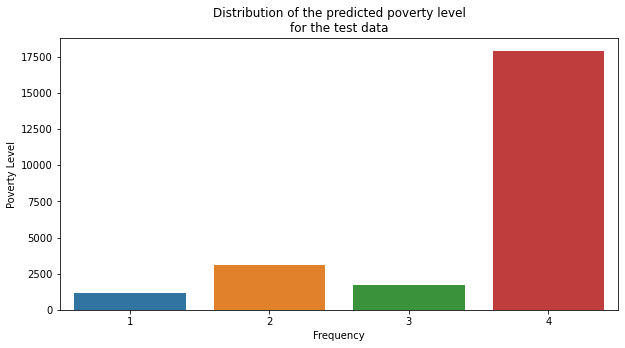

In [70]:
# Plotting the frequency of class predictions

plt.figure (figsize = (10,5))
sns.countplot (y_pred_test)
plt.xlabel ('Frequency')
plt.ylabel ('Poverty Level')
plt.title ('Distribution of the predicted poverty level\nfor the test data');

##### Project completed by: Sahaj Harnal
##### Email: sahajharnal@gmail.com